# Imports

In [1]:
!pip install -q PyWavelets fastai

In [2]:
import os
import random

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
        confusion_matrix, ConfusionMatrixDisplay,
        f1_score, multilabel_confusion_matrix, accuracy_score, classification_report)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import pywt
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
import torch.backends.cudnn as cudnn


def reproduce():
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
reproduce()

In [4]:
print(torch.__version__)

2.0.0


# Preparing Data

In [5]:
!ls ../input/ptb-xl-100-hz
# !ls ../input/ptb-xl-lead-comparison

baseline_removed_100hz.npy


In [6]:
dataset_loc = "../input/ptb-xl-100-hz"

In [7]:
signals = np.load(os.path.join(dataset_loc, "baseline_removed_100hz.npy"))
signals.shape

(21388, 12, 1000)

In [8]:
faulty_index = 12498

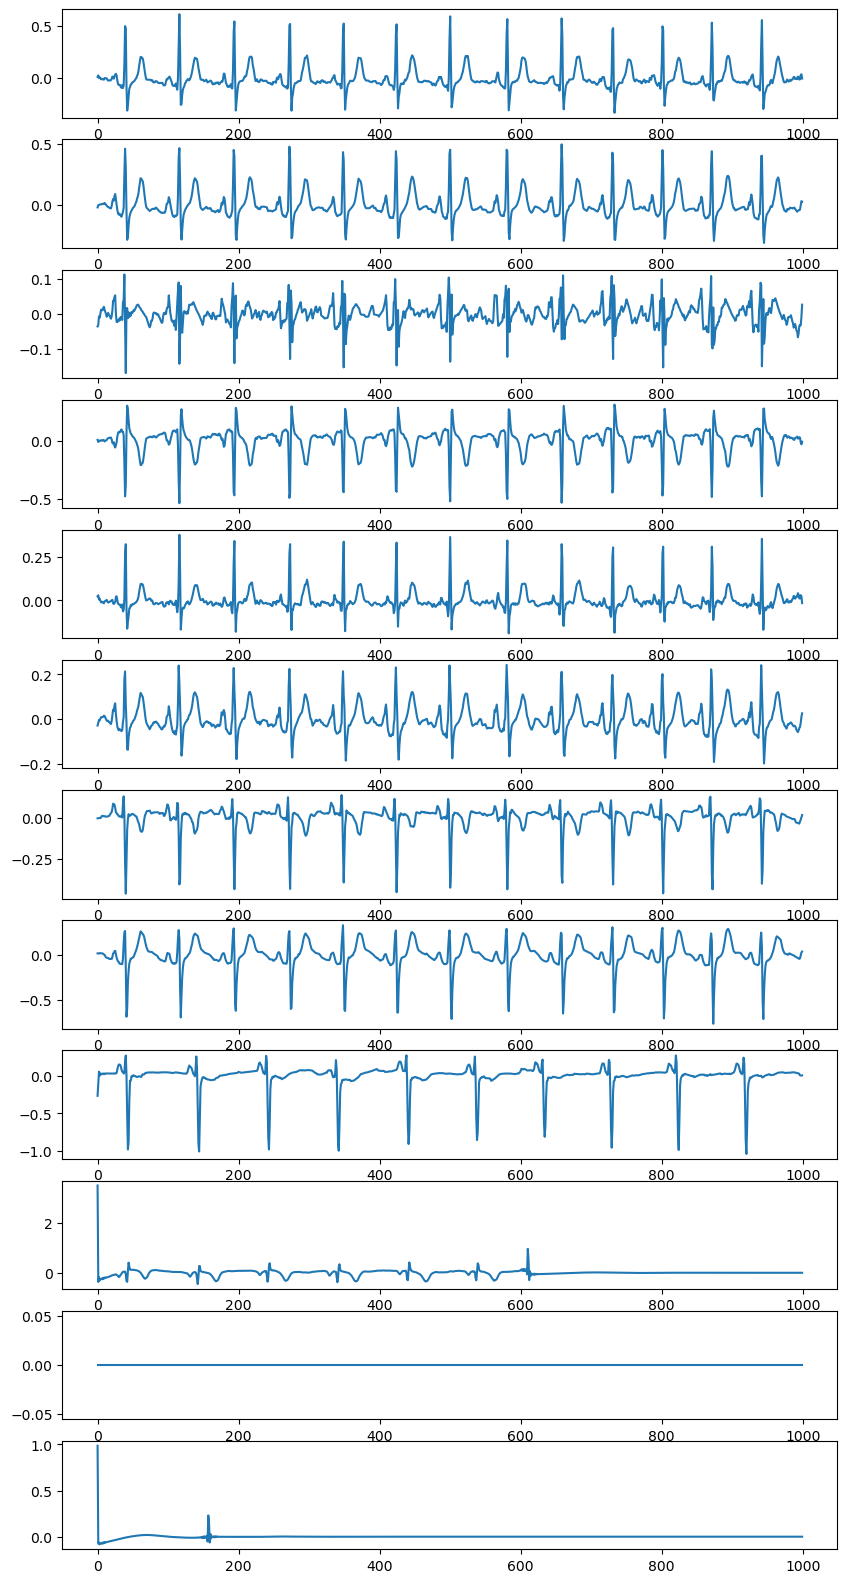

In [9]:
anomaly = signals[faulty_index]
fig, ax = plt.subplots(12, 1, figsize=(10, 20))
for i in range(12):
    ax[i].plot(anomaly[i])

In [10]:
signals = np.delete(signals, faulty_index, axis=0)
signals.shape

(21387, 12, 1000)

In [11]:
df = pd.read_csv("../input/ptb-xl-lead-comparison/labeled_df.csv")
df = df.drop(12498)
df = df.reset_index(drop=True)
df

,ecg_id,patient_id,age,sex,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,1,15709.0,56.0,1,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0
1,2,13243.0,19.0,0,2,records100/00000/00002_lr,records500/00000/00002_hr,1,0,0,0,0
2,3,20372.0,37.0,1,5,records100/00000/00003_lr,records500/00000/00003_hr,1,0,0,0,0
3,4,17014.0,24.0,0,3,records100/00000/00004_lr,records500/00000/00004_hr,1,0,0,0,0
4,5,17448.0,19.0,1,4,records100/00000/00005_lr,records500/00000/00005_hr,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21382,21833,17180.0,67.0,1,7,records100/21000/21833_lr,records500/21000/21833_hr,0,0,1,0,0
21383,21834,20703.0,300.0,0,4,records100/21000/21834_lr,records500/21000/21834_hr,1,0,0,0,0
21384,21835,19311.0,59.0,1,2,records100/21000/21835_lr,records500/21000/21835_hr,0,0,1,0,0
21385,21836,8873.0,64.0,1,8,records100/21000/21836_lr,records500/21000/21836_hr,1,0,0,0,0


In [12]:
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

In [13]:
classes2idx = {k:i for i, k in enumerate(classes)}
classes2idx

{'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}

In [14]:
test_df = df[df['strat_fold'] == 10]
val_df = df[df['strat_fold'] == 9]
train_df = df[df['strat_fold'] <= 8]

In [15]:
test_signals = signals[test_df.index]
val_signals = signals[val_df.index]
train_signals = signals[train_df.index]

In [16]:
print(test_signals.shape)
print(val_signals.shape)
print(train_signals.shape)

(2158, 12, 1000)
(2146, 12, 1000)
(17083, 12, 1000)


In [17]:
# from the metadata of WFDB sample
leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

leads_index = {l:i for i, l in enumerate(leads)}
leads_index

{'I': 0,
 'II': 1,
 'III': 2,
 'AVR': 3,
 'AVL': 4,
 'AVF': 5,
 'V1': 6,
 'V2': 7,
 'V3': 8,
 'V4': 9,
 'V5': 10,
 'V6': 11}

# PyTorch Dataset Class

In [18]:
def decompose(signal, level=3, **kwargs):
    lvl = kwargs.get("level", level)
    return pywt.wavedec(signal, 'db6', level=lvl)[0]

def minmax_norm(sig, **kwargs):
    s_min, s_max = sig.min(), sig.max()
    s_norm = (sig - s_min) / (s_max - s_min)
    return s_norm

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [20]:
class ECGDataset(Dataset):
    def __init__(self, df, signals, k, lead, transform=None, **kwargs):
        self.df = df
        self.signals = signals
        self.k = k
        self.lead = lead
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        instance = self.df.iloc[idx] # data instance
        label = instance[self.k]
        signal = self.signals[idx]
        
        if type(self.lead) == list:
            channels = []
            for i in self.lead:
                channels.append(leads_index[i])
            signal = signal[channels]
        else:
            channel = leads_index.get(self.lead, None)
            if channel is not None:
                signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, self.kwargs)
        
        return torch.tensor(signal).float(), torch.tensor(label, dtype=torch.float32)

# Defining the architecture

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes, num_channels, num_filters=64):
        super().__init__()
        n_filters = num_filters
        self.conv_1 = nn.Conv1d(num_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(num_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
        self.classifier = nn.Linear(n_filters*2, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
        
        logits = self.classifier(output_3.mean((2,)))
        res = self.sigmoid(logits)
        return res.squeeze()

# Training for individual classes

In [22]:
def create_data_splits(df, signals, BATCH_SIZE, k, lead, transform, **kwargs):
    test_df = df[df['strat_fold'] == 10]
    val_df = df[df['strat_fold'] == 9]
    train_df = df[df['strat_fold'] <= 8]
    
    test_signals = signals[test_df.index]
    val_signals = signals[val_df.index]
    train_signals = signals[train_df.index]
    
    train_dataset = ECGDataset(train_df, train_signals, k=k, lead=lead, transform=transform, **kwargs)
    val_dataset = ECGDataset(val_df, val_signals, k=k, lead=lead, transform=transform, **kwargs)
    test_dataset = ECGDataset(test_df, test_signals, k=k, lead=lead, transform=transform, **kwargs)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_dataloader, val_dataloader, test_dataloader

In [23]:
def create_leaner(train_dataloader, val_dataloader, num_channels):
    model = NeuralNetwork(num_classes=1, num_channels=num_channels, num_filters=64).to(device)
    dls = DataLoaders(train_dataloader, val_dataloader)
    loss_fn = nn.BCELoss()
    learn = Learner(
        dls,
        model,
        loss_func=loss_fn,    
        metrics=[F1ScoreMulti(sigmoid=False)]
    )
    
    return learn

In [24]:
def fit_and_test(learner, epochs, test_dataloader, model_name):
    learner.fit(
        epochs,
        lr=1e-3,
        cbs=[
            EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
            SaveModelCallback(monitor='f1_score', min_delta=0.001, fname=model_name)
        ]
    )
    
    learner.model.load_state_dict(
        torch.load(f"models/{model_name}.pth", map_location=torch.device(device)))
    learner.model.eval()
    
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            output = learner.model(inputs.to(device).float())
            output = (output > 0.5).int()
            y_pred.extend(output)
            labels = labels.data.cpu().int().numpy()
            y_true.extend(labels)
    y_true = torch.tensor(y_true).cpu()
    y_pred = torch.stack(y_pred).cpu()
    
    return y_true, y_pred

In [25]:
def evaluate_model(k, y_true, y_pred):
    print(f"Performing evaluation for class {k}")
    res = classification_report(y_true, y_pred, digits=4)
    print(res)
    
#     ConfusionMatrixDisplay.from_predictions(
#         y_true, y_pred, 
#         colorbar=True
#     )

In [26]:
def full_loop(k, ecg_leads):
    print(f"Using {ecg_leads} lead(s)")
    loaders = create_data_splits(df, signals, BATCH_SIZE, k, ecg_leads, transform, **kwargs)
    train_dataloader, val_dataloader, test_dataloader = loaders
    
    for X, y in test_dataloader:
        test_shape = X.shape
        break

    num_channels = X.shape[1]
    learn = create_leaner(train_dataloader, val_dataloader, num_channels)
    y_true, y_pred = fit_and_test(learn, num_epochs, test_dataloader, f"model_for_{k}-{ecg_leads}")
    evaluate_model(k, y_true, y_pred)
    
    return learn

In [27]:
# params
BATCH_SIZE = 32
transform = []
kwargs = {}
num_epochs = 30

In [28]:
import gc

In [29]:
def train_test_lead(lead):
    reproduce()
    for c in classes:
        full_loop(c, ecg_leads=lead)
        gc.collect()

# For Lead-I

In [30]:
train_test_lead("I")

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.465646,0.472851,0.776151,00:27
1,0.444574,0.430982,0.797243,00:21
2,0.423399,0.421054,0.800235,00:21
3,0.427965,0.430564,0.799619,00:21
4,0.425927,0.415941,0.805086,00:22
5,0.423424,0.415169,0.812742,00:21
6,0.406813,0.421341,0.803191,00:21
7,0.414022,0.409770,0.811323,00:21
8,0.421087,0.407324,0.812006,00:21
9,0.413406,0.414364,0.800761,00:21


Better model found at epoch 0 with f1_score value: 0.7761512130312749.
Better model found at epoch 1 with f1_score value: 0.797243364651133.
Better model found at epoch 2 with f1_score value: 0.8002346149226165.
Better model found at epoch 4 with f1_score value: 0.8050862851952771.
Better model found at epoch 5 with f1_score value: 0.8127422062597989.
Better model found at epoch 11 with f1_score value: 0.8199458449334502.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8641    0.7925    0.8267      1195
           1     0.7665    0.8453    0.8040       963

    accuracy                         0.8160      2158
   macro avg     0.8153    0.8189    0.8153      2158
weighted avg     0.8205    0.8160    0.8166      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.497882,0.579965,0.671294,00:21
1,0.481367,0.466300,0.647507,00:21
2,0.472639,0.481666,0.715923,00:21
3,0.459954,0.468902,0.632116,00:21
4,0.479816,0.462998,0.633668,00:21
5,0.466795,0.460115,0.640784,00:21
6,0.477893,0.476949,0.612252,00:21
7,0.470790,0.459259,0.639342,00:21
8,0.459057,0.476349,0.628579,00:21
9,0.467081,0.455676,0.684176,00:21


Better model found at epoch 0 with f1_score value: 0.6712940030509682.
Better model found at epoch 2 with f1_score value: 0.7159233813854361.
No improvement since epoch 19: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8266    0.8837    0.8542      1608
           1     0.5740    0.4582    0.5096       550

    accuracy                         0.7753      2158
   macro avg     0.7003    0.6709    0.6819      2158
weighted avg     0.7623    0.7753    0.7664      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.394151,0.398586,0.740052,00:22
1,0.392453,0.387623,0.726925,00:21
2,0.375073,0.389131,0.729405,00:21
3,0.387582,0.383902,0.745543,00:21
4,0.369118,0.384448,0.751288,00:21
5,0.377783,0.382967,0.737256,00:21
6,0.363811,0.381869,0.753842,00:21
7,0.367213,0.381213,0.757496,00:21
8,0.379254,0.377488,0.750167,00:21
9,0.386477,0.388229,0.761123,00:21


Better model found at epoch 0 with f1_score value: 0.740052086487796.
Better model found at epoch 3 with f1_score value: 0.745542646026855.
Better model found at epoch 4 with f1_score value: 0.7512878675194605.
Better model found at epoch 6 with f1_score value: 0.7538423923820585.
Better model found at epoch 7 with f1_score value: 0.7574959574959574.
Better model found at epoch 9 with f1_score value: 0.7611231799493707.
Better model found at epoch 16 with f1_score value: 0.7653074897080248.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8840    0.9078    0.8957      1637
           1     0.6834    0.6257    0.6533       521

    accuracy                         0.8397      2158
   macro avg     0.7837    0.7667    0.7745      2158
weighted avg     0.8356    0.8397    0.8372      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.423754,0.444214,0.681795,00:21
1,0.392316,0.393649,0.752116,00:21
2,0.383661,0.429250,0.701507,00:21
3,0.373336,0.380984,0.734253,00:21
4,0.394947,0.388277,0.725986,00:21
5,0.390574,0.388822,0.732458,00:21
6,0.374482,0.390613,0.731721,00:21
7,0.363315,0.396158,0.719294,00:22
8,0.377912,0.393198,0.728215,00:21


Better model found at epoch 0 with f1_score value: 0.6817948104272629.
Better model found at epoch 1 with f1_score value: 0.7521157332523716.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8598    0.9446    0.9002      1662
           1     0.7229    0.4839    0.5797       496

    accuracy                         0.8387      2158
   macro avg     0.7913    0.7143    0.7400      2158
weighted avg     0.8283    0.8387    0.8266      2158

Using I lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.315400,0.318979,0.554538,00:21
1,0.287658,0.319424,0.643572,00:22
2,0.301291,0.312502,0.609111,00:21
3,0.305581,0.331107,0.656123,00:21
4,0.307265,0.326407,0.662380,00:21
5,0.306426,0.310939,0.589162,00:21
6,0.295305,0.317776,0.645591,00:21
7,0.308719,0.343799,0.657533,00:21
8,0.307849,0.308984,0.588664,00:22
9,0.294461,0.310639,0.644874,00:21


Better model found at epoch 0 with f1_score value: 0.554538398227594.
Better model found at epoch 1 with f1_score value: 0.6435723100642852.
Better model found at epoch 3 with f1_score value: 0.656123042357387.
Better model found at epoch 4 with f1_score value: 0.6623795476892822.
No improvement since epoch 17: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9181    0.9520    0.9347      1896
           1     0.5260    0.3855    0.4449       262

    accuracy                         0.8832      2158
   macro avg     0.7221    0.6688    0.6898      2158
weighted avg     0.8705    0.8832    0.8753      2158



# For Lead-II

In [31]:
train_test_lead("II")

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.441449,0.420162,0.812787,00:22
1,0.410723,0.419209,0.811232,00:21
2,0.390504,0.397629,0.821067,00:21
3,0.392704,0.411419,0.806392,00:22
4,0.390205,0.413579,0.813059,00:21
5,0.388185,0.393279,0.823658,00:21
6,0.371444,0.387204,0.830418,00:21
7,0.385590,0.398688,0.811057,00:21
8,0.369009,0.392438,0.827926,00:21
9,0.366105,0.391648,0.817223,00:21


Better model found at epoch 0 with f1_score value: 0.8127870133858158.
Better model found at epoch 2 with f1_score value: 0.8210668051251405.
Better model found at epoch 5 with f1_score value: 0.8236575044167797.
Better model found at epoch 6 with f1_score value: 0.8304179455051102.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8591    0.7858    0.8208      1195
           1     0.7596    0.8401    0.7978       963

    accuracy                         0.8100      2158
   macro avg     0.8094    0.8129    0.8093      2158
weighted avg     0.8147    0.8100    0.8106      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.460869,0.491495,0.711534,00:21
1,0.439471,0.428767,0.694536,00:21
2,0.437330,0.424034,0.724099,00:21
3,0.409076,0.424309,0.676408,00:21
4,0.440372,0.430667,0.684436,00:21
5,0.415633,0.434252,0.662522,00:21
6,0.414189,0.422172,0.732972,00:21
7,0.409348,0.418553,0.736274,00:21
8,0.402093,0.414031,0.731963,00:22
9,0.421926,0.416822,0.692021,00:21


Better model found at epoch 0 with f1_score value: 0.7115336739182134.
Better model found at epoch 2 with f1_score value: 0.7240991885113917.
Better model found at epoch 6 with f1_score value: 0.7329720834085938.
Better model found at epoch 7 with f1_score value: 0.7362736396531713.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8370    0.9167    0.8750      1608
           1     0.6625    0.4782    0.5554       550

    accuracy                         0.8049      2158
   macro avg     0.7497    0.6974    0.7152      2158
weighted avg     0.7925    0.8049    0.7936      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.386916,0.393865,0.737740,00:21
1,0.378664,0.385746,0.711808,00:21
2,0.346059,0.386395,0.715958,00:21
3,0.354774,0.383716,0.749528,00:21
4,0.355360,0.385829,0.729621,00:21
5,0.357493,0.372944,0.742258,00:21
6,0.370383,0.376594,0.740795,00:21
7,0.363181,0.364894,0.743888,00:21
8,0.362845,0.365974,0.754577,00:21
9,0.370337,0.375568,0.746250,00:21


Better model found at epoch 0 with f1_score value: 0.7377404012724811.
Better model found at epoch 3 with f1_score value: 0.7495280399941966.
Better model found at epoch 8 with f1_score value: 0.7545772568261324.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8716    0.9291    0.8995      1637
           1     0.7191    0.5701    0.6360       521

    accuracy                         0.8424      2158
   macro avg     0.7954    0.7496    0.7677      2158
weighted avg     0.8348    0.8424    0.8359      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.379108,0.356144,0.780336,00:21
1,0.342186,0.352922,0.762394,00:21
2,0.329193,0.338144,0.790541,00:21
3,0.327804,0.336258,0.771149,00:21
4,0.329467,0.329341,0.798953,00:21
5,0.322998,0.321890,0.804703,00:21
6,0.318567,0.329282,0.798400,00:21
7,0.309781,0.322810,0.793316,00:21
8,0.313902,0.319379,0.804924,00:21
9,0.293846,0.320520,0.811734,00:21


Better model found at epoch 0 with f1_score value: 0.7803362831917806.
Better model found at epoch 2 with f1_score value: 0.7905411018075492.
Better model found at epoch 4 with f1_score value: 0.7989530922431866.
Better model found at epoch 5 with f1_score value: 0.8047032445265102.
Better model found at epoch 9 with f1_score value: 0.8117335632087455.
Better model found at epoch 10 with f1_score value: 0.8150534375725089.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8958    0.9314    0.9133      1662
           1     0.7349    0.6371    0.6825       496

    accuracy                         0.8638      2158
   macro avg     0.8154    0.7843    0.7979      2158
weighted avg     0.8588    0.8638    0.8602      2158

Using II lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.328296,0.334656,0.556744,00:21
1,0.290800,0.337433,0.556327,00:21
2,0.306845,0.325203,0.544465,00:21
3,0.317811,0.315165,0.587947,00:21
4,0.320879,0.319140,0.575605,00:21
5,0.313989,0.319082,0.547214,00:21
6,0.296205,0.320383,0.601263,00:21
7,0.308310,0.315015,0.603826,00:21
8,0.307370,0.314241,0.586005,00:21


Better model found at epoch 0 with f1_score value: 0.5567436185645253.
Better model found at epoch 3 with f1_score value: 0.5879465348892594.
Better model found at epoch 6 with f1_score value: 0.6012626321055484.
Better model found at epoch 7 with f1_score value: 0.60382626181151.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.8995    0.9726    0.9346      1896
           1     0.5185    0.2137    0.3027       262

    accuracy                         0.8804      2158
   macro avg     0.7090    0.5932    0.6187      2158
weighted avg     0.8533    0.8804    0.8579      2158



# For Lead-III

In [32]:
train_test_lead("III")

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.550708,0.541434,0.706444,00:21
1,0.535240,0.518437,0.728961,00:21
2,0.520501,0.532865,0.718246,00:21
3,0.509058,0.525590,0.723513,00:21
4,0.504890,0.517253,0.734378,00:21
5,0.508245,0.509099,0.739944,00:21
6,0.497983,0.509969,0.738343,00:21
7,0.489156,0.502679,0.742799,00:21
8,0.486012,0.505013,0.745430,00:21
9,0.481722,0.493952,0.752330,00:21


Better model found at epoch 0 with f1_score value: 0.7064435391632189.
Better model found at epoch 1 with f1_score value: 0.7289608287358492.
Better model found at epoch 4 with f1_score value: 0.7343782572441109.
Better model found at epoch 5 with f1_score value: 0.7399438875643778.
Better model found at epoch 7 with f1_score value: 0.7427985924320628.
Better model found at epoch 8 with f1_score value: 0.7454297083053729.
Better model found at epoch 9 with f1_score value: 0.7523299770050866.
Better model found at epoch 11 with f1_score value: 0.7548823917726357.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8081    0.6979    0.7490      1195
           1     0.6794    0.7944    0.7324       963

    accuracy                         0.7410      2158
   macro avg     0.7438    0.7462    0.7407      2158
weighted avg     0.7507    0.7410    0.7416      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.475723,0.447216,0.678440,00:21
1,0.439114,0.474231,0.720897,00:21
2,0.440215,0.436761,0.670519,00:21
3,0.425593,0.451569,0.655610,00:21
4,0.436697,0.434490,0.677526,00:21
5,0.424387,0.434038,0.674115,00:21
6,0.416789,0.429896,0.671562,00:21
7,0.416918,0.427524,0.724468,00:21
8,0.411403,0.427263,0.688058,00:21
9,0.433250,0.422745,0.703139,00:21


Better model found at epoch 0 with f1_score value: 0.6784404770462016.
Better model found at epoch 1 with f1_score value: 0.7208970103112635.
Better model found at epoch 7 with f1_score value: 0.724468147808315.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8407    0.8993    0.8690      1608
           1     0.6301    0.5018    0.5587       550

    accuracy                         0.7980      2158
   macro avg     0.7354    0.7005    0.7138      2158
weighted avg     0.7870    0.7980    0.7899      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.535614,0.541814,0.453132,00:21
1,0.523611,0.532671,0.433547,00:21
2,0.512268,0.527995,0.433388,00:21
3,0.503041,0.524324,0.536265,00:21
4,0.506386,0.524612,0.590250,00:21
5,0.497811,0.510151,0.551022,00:21
6,0.506432,0.511757,0.527464,00:21
7,0.496398,0.508648,0.512525,00:21
8,0.488730,0.507031,0.569486,00:21
9,0.497238,0.525402,0.631027,00:21


Better model found at epoch 0 with f1_score value: 0.45313173546877317.
Better model found at epoch 3 with f1_score value: 0.5362651848885329.
Better model found at epoch 4 with f1_score value: 0.5902500903473875.
Better model found at epoch 9 with f1_score value: 0.6310274576974981.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8082    0.8650    0.8356      1637
           1     0.4557    0.3551    0.3991       521

    accuracy                         0.7419      2158
   macro avg     0.6319    0.6100    0.6174      2158
weighted avg     0.7231    0.7419    0.7303      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.450470,0.457670,0.714919,00:21
1,0.411256,0.396648,0.712704,00:21
2,0.404412,0.390214,0.715031,00:21
3,0.387001,0.383433,0.708185,00:21
4,0.394552,0.383175,0.708993,00:21
5,0.383729,0.370655,0.739913,00:21
6,0.374461,0.362241,0.744118,00:21
7,0.352449,0.379575,0.730952,00:21
8,0.375774,0.371289,0.743647,00:21
9,0.358473,0.359721,0.751535,00:21


Better model found at epoch 0 with f1_score value: 0.714919272430002.
Better model found at epoch 5 with f1_score value: 0.739912972373109.
Better model found at epoch 6 with f1_score value: 0.7441184293798784.
Better model found at epoch 9 with f1_score value: 0.7515349826418267.
Better model found at epoch 14 with f1_score value: 0.754272507586827.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8618    0.9452    0.9016      1662
           1     0.7284    0.4919    0.5872       496

    accuracy                         0.8411      2158
   macro avg     0.7951    0.7186    0.7444      2158
weighted avg     0.8311    0.8411    0.8293      2158

Using III lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.352419,0.360266,0.524955,00:21
1,0.335031,0.356662,0.504978,00:21
2,0.338631,0.356776,0.541130,00:21
3,0.346504,0.349783,0.522707,00:21
4,0.338192,0.353798,0.508422,00:21
5,0.343441,0.351294,0.519146,00:21
6,0.336559,0.346533,0.540301,00:21
7,0.332408,0.349364,0.572474,00:21
8,0.339335,0.343274,0.509573,00:21
9,0.336542,0.343857,0.558074,00:21


Better model found at epoch 0 with f1_score value: 0.524954989522151.
Better model found at epoch 2 with f1_score value: 0.54112989954923.
Better model found at epoch 7 with f1_score value: 0.5724737199050526.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.8940    0.9699    0.9304      1896
           1     0.4356    0.1679    0.2424       262

    accuracy                         0.8726      2158
   macro avg     0.6648    0.5689    0.5864      2158
weighted avg     0.8384    0.8726    0.8469      2158



# For Lead-AVR

In [33]:
train_test_lead("AVR")

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.436928,0.419856,0.802466,00:21
1,0.403751,0.408187,0.810700,00:21
2,0.387569,0.388408,0.827005,00:21
3,0.389490,0.441043,0.783410,00:21
4,0.379877,0.396523,0.824899,00:21
5,0.388186,0.381538,0.825104,00:21
6,0.366618,0.388667,0.816508,00:21
7,0.383398,0.388042,0.813042,00:21
8,0.370823,0.383105,0.824753,00:21
9,0.372815,0.383614,0.820328,00:21


Better model found at epoch 0 with f1_score value: 0.8024656566141282.
Better model found at epoch 1 with f1_score value: 0.810699663582331.
Better model found at epoch 2 with f1_score value: 0.8270045595484101.
Better model found at epoch 15 with f1_score value: 0.8293076650254527.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.9058    0.7640    0.8289      1195
           1     0.7548    0.9013    0.8216       963

    accuracy                         0.8253      2158
   macro avg     0.8303    0.8327    0.8252      2158
weighted avg     0.8384    0.8253    0.8256      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.463374,0.449114,0.704379,00:21
1,0.457163,0.432132,0.701709,00:21
2,0.449495,0.437365,0.680191,00:21
3,0.430962,0.461673,0.607994,00:21
4,0.459212,0.440430,0.657645,00:21
5,0.435208,0.436748,0.703954,00:21
6,0.451365,0.437004,0.694448,00:21


Better model found at epoch 0 with f1_score value: 0.7043794234718773.
No improvement since epoch 1: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8256    0.8980    0.8603      1608
           1     0.5990    0.4455    0.5109       550

    accuracy                         0.7827      2158
   macro avg     0.7123    0.6717    0.6856      2158
weighted avg     0.7679    0.7827    0.7713      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.348841,0.366297,0.716318,00:21
1,0.347048,0.340381,0.759979,00:21
2,0.316980,0.335420,0.785826,00:21
3,0.325273,0.346552,0.795524,00:21
4,0.326933,0.345709,0.751782,00:21
5,0.328127,0.341504,0.797527,00:21
6,0.325510,0.339312,0.804065,00:21
7,0.329494,0.331306,0.788934,00:21
8,0.323060,0.329650,0.783471,00:21
9,0.336345,0.361639,0.794608,00:21


Better model found at epoch 0 with f1_score value: 0.716318087303232.
Better model found at epoch 1 with f1_score value: 0.7599788081549359.
Better model found at epoch 2 with f1_score value: 0.7858261321439757.
Better model found at epoch 3 with f1_score value: 0.7955235150294837.
Better model found at epoch 5 with f1_score value: 0.7975265262015463.
Better model found at epoch 6 with f1_score value: 0.8040650634902798.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.9056    0.9139    0.9097      1637
           1     0.7213    0.7006    0.7108       521

    accuracy                         0.8624      2158
   macro avg     0.8135    0.8072    0.8103      2158
weighted avg     0.8611    0.8624    0.8617      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.373219,0.382625,0.776058,00:21
1,0.345322,0.366537,0.770253,00:21
2,0.334347,0.372003,0.767735,00:21
3,0.329067,0.348715,0.760468,00:21
4,0.347298,0.350383,0.770538,00:21
5,0.350054,0.351209,0.785066,00:21
6,0.330982,0.350872,0.786415,00:21
7,0.321080,0.337430,0.773085,00:21
8,0.333518,0.345726,0.767413,00:21
9,0.327917,0.341038,0.770777,00:21


Better model found at epoch 0 with f1_score value: 0.7760584376863446.
Better model found at epoch 5 with f1_score value: 0.7850663978455159.
Better model found at epoch 6 with f1_score value: 0.7864154597027531.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8816    0.9278    0.9041      1662
           1     0.7066    0.5827    0.6387       496

    accuracy                         0.8485      2158
   macro avg     0.7941    0.7552    0.7714      2158
weighted avg     0.8414    0.8485    0.8431      2158

Using AVR lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.307390,0.309506,0.625906,00:21
1,0.275003,0.309356,0.648050,00:21
2,0.285640,0.304773,0.601108,00:21
3,0.300364,0.294618,0.616129,00:21
4,0.303622,0.298386,0.626701,00:21
5,0.291007,0.299448,0.631356,00:21
6,0.279911,0.297626,0.665392,00:21
7,0.298813,0.302892,0.661227,00:21
8,0.289267,0.300442,0.611965,00:21


Better model found at epoch 0 with f1_score value: 0.6259064006860389.
Better model found at epoch 1 with f1_score value: 0.6480500465333172.
Better model found at epoch 6 with f1_score value: 0.665392250569811.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9143    0.9684    0.9406      1896
           1     0.6000    0.3435    0.4369       262

    accuracy                         0.8925      2158
   macro avg     0.7572    0.6559    0.6887      2158
weighted avg     0.8762    0.8925    0.8794      2158



# For Lead-AVL

In [34]:
train_test_lead("AVL")

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.521167,0.504974,0.739144,00:21
1,0.503338,0.523132,0.721724,00:21
2,0.486474,0.491164,0.757668,00:21
3,0.480678,0.499282,0.743436,00:21
4,0.478313,0.480426,0.759903,00:21
5,0.487804,0.469161,0.761221,00:21
6,0.471972,0.502246,0.746292,00:21
7,0.466370,0.486730,0.756512,00:21
8,0.460925,0.467994,0.767967,00:21
9,0.455213,0.466101,0.766102,00:21


Better model found at epoch 0 with f1_score value: 0.739143746514002.
Better model found at epoch 2 with f1_score value: 0.7576676751541178.
Better model found at epoch 4 with f1_score value: 0.7599034738927424.
Better model found at epoch 5 with f1_score value: 0.7612205166327095.
Better model found at epoch 8 with f1_score value: 0.7679666044209257.
Better model found at epoch 11 with f1_score value: 0.7728577852513676.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8332    0.7439    0.7860      1195
           1     0.7195    0.8152    0.7644       963

    accuracy                         0.7757      2158
   macro avg     0.7764    0.7795    0.7752      2158
weighted avg     0.7825    0.7757    0.7764      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.505353,0.483144,0.664808,00:21
1,0.466947,0.487433,0.666324,00:21
2,0.452948,0.461683,0.670671,00:21
3,0.441075,0.471682,0.620362,00:21
4,0.465965,0.488061,0.587760,00:21
5,0.452580,0.464042,0.631411,00:21
6,0.450954,0.463560,0.629952,00:21
7,0.449139,0.461822,0.691437,00:21


Better model found at epoch 0 with f1_score value: 0.6648080605376478.
Better model found at epoch 1 with f1_score value: 0.6663239326282804.
Better model found at epoch 2 with f1_score value: 0.6706713479135223.
Better model found at epoch 7 with f1_score value: 0.6914373543556944.
No improvement since epoch 2: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8294    0.8769    0.8525      1608
           1     0.5677    0.4727    0.5159       550

    accuracy                         0.7739      2158
   macro avg     0.6985    0.6748    0.6842      2158
weighted avg     0.7627    0.7739    0.7667      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.484657,0.484741,0.598515,00:21
1,0.487844,0.483745,0.539083,00:21
2,0.470412,0.473132,0.602600,00:21
3,0.477398,0.475971,0.613060,00:21
4,0.463185,0.468611,0.635245,00:21
5,0.464047,0.473047,0.589183,00:21
6,0.451034,0.473044,0.628834,00:21
7,0.451977,0.464725,0.670042,00:21
8,0.463237,0.463927,0.628496,00:21
9,0.475556,0.470284,0.663863,00:21


Better model found at epoch 0 with f1_score value: 0.5985149962102746.
Better model found at epoch 2 with f1_score value: 0.602600339174675.
Better model found at epoch 3 with f1_score value: 0.6130596217544609.
Better model found at epoch 4 with f1_score value: 0.6352448201977983.
Better model found at epoch 7 with f1_score value: 0.67004173678256.
Better model found at epoch 17 with f1_score value: 0.67375520538394.
No improvement since epoch 14: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8276    0.8943    0.8597      1637
           1     0.5553    0.4146    0.4747       521

    accuracy                         0.7785      2158
   macro avg     0.6914    0.6545    0.6672      2158
weighted avg     0.7618    0.7785    0.7667      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.446332,0.433898,0.711092,00:21
1,0.423338,0.398256,0.716153,00:21
2,0.414997,0.412345,0.704344,00:21
3,0.391516,0.405819,0.700155,00:21
4,0.411622,0.383495,0.708108,00:21
5,0.396564,0.387499,0.733033,00:21
6,0.393447,0.376590,0.725279,00:21
7,0.368346,0.408190,0.703069,00:21
8,0.390024,0.384222,0.719943,00:21
9,0.369752,0.380404,0.736225,00:21


Better model found at epoch 0 with f1_score value: 0.7110919455604872.
Better model found at epoch 1 with f1_score value: 0.7161532904725352.
Better model found at epoch 5 with f1_score value: 0.7330327933190073.
Better model found at epoch 9 with f1_score value: 0.7362245850381727.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8519    0.9519    0.8991      1662
           1     0.7342    0.4456    0.5546       496

    accuracy                         0.8355      2158
   macro avg     0.7931    0.6987    0.7268      2158
weighted avg     0.8249    0.8355    0.8199      2158

Using AVL lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.343556,0.354353,0.498751,00:21
1,0.321297,0.340130,0.541873,00:21
2,0.326613,0.338991,0.573323,00:21
3,0.333055,0.330552,0.576524,00:21
4,0.323562,0.342801,0.619258,00:21
5,0.329174,0.331321,0.566605,00:21
6,0.328302,0.334606,0.595776,00:21
7,0.325854,0.339295,0.580967,00:21
8,0.332887,0.329559,0.582958,00:21


Better model found at epoch 0 with f1_score value: 0.49875148407249764.
Better model found at epoch 1 with f1_score value: 0.5418733011923893.
Better model found at epoch 2 with f1_score value: 0.573323029482269.
Better model found at epoch 3 with f1_score value: 0.5765238802101741.
Better model found at epoch 4 with f1_score value: 0.6192580862157707.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9033    0.9562    0.9290      1896
           1     0.4503    0.2595    0.3293       262

    accuracy                         0.8716      2158
   macro avg     0.6768    0.6079    0.6292      2158
weighted avg     0.8483    0.8716    0.8562      2158



# For Lead-AVF

In [35]:
train_test_lead("AVF")

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.489104,0.502214,0.745146,00:21
1,0.465099,0.472833,0.774723,00:21
2,0.451049,0.470458,0.769380,00:21
3,0.447858,0.480128,0.757136,00:21
4,0.451443,0.460759,0.773916,00:21
5,0.448799,0.455286,0.778615,00:21
6,0.435169,0.449421,0.784705,00:21
7,0.433224,0.461833,0.772181,00:21
8,0.437575,0.458906,0.780512,00:21
9,0.430653,0.453399,0.786122,00:21


Better model found at epoch 0 with f1_score value: 0.7451463940100304.
Better model found at epoch 1 with f1_score value: 0.774723429725689.
Better model found at epoch 5 with f1_score value: 0.7786152903030112.
Better model found at epoch 6 with f1_score value: 0.7847050653936881.
Better model found at epoch 9 with f1_score value: 0.7861219446675691.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.7877    0.8008    0.7942      1195
           1     0.7476    0.7321    0.7398       963

    accuracy                         0.7702      2158
   macro avg     0.7676    0.7665    0.7670      2158
weighted avg     0.7698    0.7702    0.7699      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.451814,0.506089,0.694703,00:21
1,0.417271,0.423390,0.705665,00:21
2,0.430608,0.409405,0.704954,00:21
3,0.401852,0.437952,0.629999,00:21
4,0.428205,0.407691,0.716931,00:21
5,0.406668,0.416142,0.698575,00:21
6,0.400623,0.408014,0.714897,00:21
7,0.400858,0.407679,0.733494,00:21
8,0.389139,0.412873,0.702126,00:21
9,0.407484,0.403678,0.705411,00:21


Better model found at epoch 0 with f1_score value: 0.694703025426644.
Better model found at epoch 1 with f1_score value: 0.7056645178987794.
Better model found at epoch 4 with f1_score value: 0.7169305905988514.
Better model found at epoch 7 with f1_score value: 0.7334937923757816.
Better model found at epoch 10 with f1_score value: 0.73725565717332.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8450    0.9117    0.8771      1608
           1     0.6643    0.5109    0.5776       550

    accuracy                         0.8095      2158
   macro avg     0.7546    0.7113    0.7273      2158
weighted avg     0.7989    0.8095    0.8007      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.467070,0.472952,0.593045,00:21
1,0.451277,0.485915,0.626119,00:21
2,0.433818,0.480716,0.571710,00:21
3,0.431530,0.474034,0.604095,00:21
4,0.440498,0.459270,0.653898,00:21
5,0.436245,0.460193,0.643610,00:21
6,0.450664,0.467765,0.643735,00:21
7,0.435444,0.466263,0.593900,00:22
8,0.428686,0.457608,0.667869,00:21
9,0.425480,0.458225,0.654561,00:21


Better model found at epoch 0 with f1_score value: 0.593044919855096.
Better model found at epoch 1 with f1_score value: 0.6261188904712678.
Better model found at epoch 4 with f1_score value: 0.653898336611715.
Better model found at epoch 8 with f1_score value: 0.6678691955383166.
Better model found at epoch 15 with f1_score value: 0.6733814506909824.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8288    0.9224    0.8731      1637
           1     0.6220    0.4012    0.4877       521

    accuracy                         0.7966      2158
   macro avg     0.7254    0.6618    0.6804      2158
weighted avg     0.7788    0.7966    0.7801      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.424042,0.450070,0.729775,00:21
1,0.393191,0.396347,0.718862,00:21
2,0.380009,0.384292,0.738548,00:21
3,0.367436,0.365034,0.734030,00:21
4,0.368132,0.371781,0.745076,00:21
5,0.357475,0.363694,0.767062,00:21
6,0.354186,0.354629,0.774210,00:21
7,0.344666,0.352813,0.749658,00:21
8,0.346579,0.347839,0.774328,00:21
9,0.326188,0.356889,0.771870,00:21


Better model found at epoch 0 with f1_score value: 0.729775428089915.
Better model found at epoch 2 with f1_score value: 0.7385477582846004.
Better model found at epoch 4 with f1_score value: 0.7450763175865097.
Better model found at epoch 5 with f1_score value: 0.7670615207761418.
Better model found at epoch 6 with f1_score value: 0.7742104527194802.
Better model found at epoch 12 with f1_score value: 0.7755268879665522.
Better model found at epoch 14 with f1_score value: 0.7854215985472937.
No improvement since epoch 18: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8726    0.9356    0.9030      1662
           1     0.7154    0.5423    0.6170       496

    accuracy                         0.8452      2158
   macro avg     0.7940    0.7390    0.7600      2158
weighted avg     0.8365    0.8452    0.8373      2158

Using AVF lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.345510,0.394293,0.585930,00:21
1,0.324264,0.353102,0.498507,00:21
2,0.329911,0.351199,0.515243,00:21
3,0.337324,0.341254,0.544137,00:21
4,0.334948,0.346390,0.524323,00:22
5,0.337228,0.344087,0.501765,00:21
6,0.318053,0.341630,0.570644,00:21
7,0.325197,0.349435,0.591362,00:21
8,0.326478,0.351686,0.587308,00:21


Better model found at epoch 0 with f1_score value: 0.5859297979540288.
Better model found at epoch 7 with f1_score value: 0.5913620143384403.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.8961    0.9647    0.9291      1896
           1     0.4274    0.1908    0.2639       262

    accuracy                         0.8707      2158
   macro avg     0.6617    0.5778    0.5965      2158
weighted avg     0.8392    0.8707    0.8484      2158



# For Lead-V1

In [36]:
train_test_lead("V1")

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.549022,0.541275,0.718538,00:21
1,0.518175,0.553940,0.715741,00:21
2,0.502821,0.512336,0.730122,00:21
3,0.495828,0.524033,0.726018,00:21
4,0.483034,0.530499,0.736567,00:21
5,0.487401,0.500520,0.741543,00:21
6,0.483628,0.523504,0.736680,00:21
7,0.474499,0.508420,0.739049,00:21
8,0.473024,0.502267,0.734514,00:21
9,0.469389,0.493421,0.744665,00:22


Better model found at epoch 0 with f1_score value: 0.7185383686932727.
Better model found at epoch 2 with f1_score value: 0.7301216248558561.
Better model found at epoch 4 with f1_score value: 0.7365667646098596.
Better model found at epoch 5 with f1_score value: 0.7415430303898815.
Better model found at epoch 9 with f1_score value: 0.7446647716723629.
Better model found at epoch 10 with f1_score value: 0.7458127684108856.
Better model found at epoch 15 with f1_score value: 0.7506046625423788.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.7970    0.7590    0.7775      1195
           1     0.7176    0.7601    0.7383       963

    accuracy                         0.7595      2158
   macro avg     0.7573    0.7596    0.7579      2158
weighted avg     0.7616    0.7595    0.7600      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.479546,0.477790,0.654499,00:21
1,0.465330,0.476780,0.619069,00:21
2,0.454355,0.466020,0.708075,00:21
3,0.441311,0.458388,0.684278,00:21
4,0.460223,0.463515,0.681053,00:21
5,0.449018,0.454290,0.674667,00:21
6,0.455419,0.453931,0.685050,00:21
7,0.450564,0.451061,0.666658,00:21
8,0.446978,0.452667,0.665799,00:22
9,0.453465,0.448964,0.689967,00:21


Better model found at epoch 0 with f1_score value: 0.6544990208854733.
Better model found at epoch 2 with f1_score value: 0.7080754967992758.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8296    0.8993    0.8630      1608
           1     0.6096    0.4600    0.5244       550

    accuracy                         0.7873      2158
   macro avg     0.7196    0.6796    0.6937      2158
weighted avg     0.7735    0.7873    0.7767      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.504380,0.519948,0.538194,00:21
1,0.501572,0.522844,0.472857,00:21
2,0.474335,0.523959,0.500532,00:21
3,0.477165,0.495470,0.612663,00:21
4,0.478022,0.490146,0.610646,00:21
5,0.470180,0.489111,0.599085,00:21
6,0.473630,0.486043,0.615053,00:22
7,0.460065,0.495678,0.593951,00:21
8,0.465132,0.494846,0.569908,00:21
9,0.469206,0.499864,0.618764,00:21


Better model found at epoch 0 with f1_score value: 0.5381943568819108.
Better model found at epoch 3 with f1_score value: 0.6126629131652036.
Better model found at epoch 6 with f1_score value: 0.6150532546839945.
Better model found at epoch 9 with f1_score value: 0.6187638551348527.
Better model found at epoch 15 with f1_score value: 0.6516068807370479.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8258    0.9151    0.8682      1637
           1     0.5959    0.3935    0.4740       521

    accuracy                         0.7892      2158
   macro avg     0.7109    0.6543    0.6711      2158
weighted avg     0.7703    0.7892    0.7730      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.367861,0.400262,0.758348,00:21
1,0.353278,0.362610,0.771696,00:21
2,0.338541,0.360068,0.781420,00:21
3,0.340453,0.354541,0.765929,00:21
4,0.349666,0.350678,0.782218,00:21
5,0.341479,0.346949,0.784830,00:21
6,0.319285,0.354143,0.779733,00:21
7,0.309869,0.346225,0.782800,00:21
8,0.334699,0.343718,0.779626,00:21
9,0.314824,0.346059,0.777513,00:21


Better model found at epoch 0 with f1_score value: 0.7583475624116817.
Better model found at epoch 1 with f1_score value: 0.7716959397191956.
Better model found at epoch 2 with f1_score value: 0.7814204043159304.
Better model found at epoch 5 with f1_score value: 0.7848299843123931.
Better model found at epoch 13 with f1_score value: 0.788886484157943.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8734    0.9591    0.9143      1662
           1     0.7958    0.5343    0.6393       496

    accuracy                         0.8614      2158
   macro avg     0.8346    0.7467    0.7768      2158
weighted avg     0.8556    0.8614    0.8511      2158

Using V1 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.321337,0.313962,0.563616,00:21
1,0.292716,0.316301,0.603355,00:21
2,0.301429,0.318363,0.633299,00:21
3,0.310857,0.310078,0.601248,00:21
4,0.311446,0.316124,0.616041,00:21
5,0.315029,0.307734,0.574528,00:21
6,0.296231,0.313424,0.584427,00:21
7,0.309520,0.315156,0.649687,00:21
8,0.306409,0.310679,0.561039,00:21
9,0.297289,0.308178,0.602857,00:21


Better model found at epoch 0 with f1_score value: 0.5636158105247653.
Better model found at epoch 1 with f1_score value: 0.603354844091949.
Better model found at epoch 2 with f1_score value: 0.6332987133433065.
Better model found at epoch 7 with f1_score value: 0.649686727391987.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9076    0.9589    0.9325      1896
           1     0.4968    0.2939    0.3693       262

    accuracy                         0.8781      2158
   macro avg     0.7022    0.6264    0.6509      2158
weighted avg     0.8578    0.8781    0.8642      2158



# For Lead-V2

In [37]:
train_test_lead("V2")

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.540681,0.531385,0.725070,00:21
1,0.528883,0.517244,0.738610,00:21
2,0.505242,0.508663,0.741379,00:21
3,0.491233,0.497911,0.743654,00:21
4,0.494332,0.499810,0.743687,00:21
5,0.486718,0.506053,0.725810,00:21
6,0.481919,0.507062,0.738802,00:21
7,0.463807,0.500389,0.739849,00:21
8,0.486240,0.497537,0.744072,00:21


Better model found at epoch 0 with f1_score value: 0.7250696586897912.
Better model found at epoch 1 with f1_score value: 0.7386098575508986.
Better model found at epoch 2 with f1_score value: 0.7413792541878244.
Better model found at epoch 3 with f1_score value: 0.7436540362922077.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.7862    0.7414    0.7631      1195
           1     0.7003    0.7497    0.7242       963

    accuracy                         0.7451      2158
   macro avg     0.7432    0.7456    0.7437      2158
weighted avg     0.7478    0.7451    0.7457      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.474927,0.512322,0.711992,00:21
1,0.444998,0.436331,0.700688,00:21
2,0.425520,0.436496,0.719346,00:21
3,0.421783,0.443869,0.687734,00:21
4,0.438508,0.431694,0.713700,00:21
5,0.414468,0.436651,0.718841,00:21
6,0.421804,0.442390,0.720613,00:22
7,0.426037,0.443390,0.730371,00:22
8,0.426531,0.421799,0.718646,00:21
9,0.430234,0.413175,0.728646,00:21


Better model found at epoch 0 with f1_score value: 0.7119917133914297.
Better model found at epoch 2 with f1_score value: 0.7193459641134059.
Better model found at epoch 6 with f1_score value: 0.720613217362865.
Better model found at epoch 7 with f1_score value: 0.73037117804734.
Better model found at epoch 12 with f1_score value: 0.7443052254650315.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8409    0.9465    0.8906      1608
           1     0.7529    0.4764    0.5835       550

    accuracy                         0.8267      2158
   macro avg     0.7969    0.7114    0.7370      2158
weighted avg     0.8185    0.8267    0.8123      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.497695,0.562105,0.636226,00:21
1,0.490082,0.495248,0.486908,00:21
2,0.469742,0.511584,0.494063,00:21
3,0.475841,0.487687,0.525604,00:21
4,0.480288,0.478395,0.601893,00:21
5,0.471418,0.478070,0.603777,00:21
6,0.478692,0.485617,0.644981,00:21
7,0.462960,0.473888,0.624237,00:21
8,0.468159,0.472092,0.604484,00:21
9,0.470324,0.478804,0.623902,00:21


Better model found at epoch 0 with f1_score value: 0.6362256880755396.
Better model found at epoch 6 with f1_score value: 0.6449813930657535.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8242    0.9078    0.8640      1637
           1     0.5746    0.3916    0.4658       521

    accuracy                         0.7831      2158
   macro avg     0.6994    0.6497    0.6649      2158
weighted avg     0.7639    0.7831    0.7678      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.407479,0.421138,0.745330,00:21
1,0.379988,0.390367,0.735724,00:21
2,0.368372,0.378994,0.750627,00:21
3,0.366282,0.384884,0.726527,00:21
4,0.382471,0.386862,0.731484,00:22
5,0.367546,0.390704,0.768372,00:21
6,0.342354,0.370678,0.747654,00:21
7,0.334756,0.376503,0.740894,00:21
8,0.358508,0.373392,0.757312,00:21
9,0.344416,0.382170,0.764492,00:21


Better model found at epoch 0 with f1_score value: 0.7453300239663523.
Better model found at epoch 2 with f1_score value: 0.7506272837216108.
Better model found at epoch 5 with f1_score value: 0.7683719088493767.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8833    0.9200    0.9013      1662
           1     0.6885    0.5927    0.6371       496

    accuracy                         0.8448      2158
   macro avg     0.7859    0.7564    0.7692      2158
weighted avg     0.8385    0.8448    0.8405      2158

Using V2 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.344788,0.360994,0.488659,00:21
1,0.318581,0.352289,0.528278,00:21
2,0.324700,0.359080,0.578205,00:21
3,0.344243,0.349360,0.551289,00:21
4,0.332909,0.344480,0.581558,00:21
5,0.336210,0.341003,0.556327,00:21
6,0.322236,0.339413,0.537931,00:21
7,0.327263,0.347000,0.594341,00:21
8,0.328789,0.334436,0.544906,00:21
9,0.325768,0.336657,0.550270,00:21


Better model found at epoch 0 with f1_score value: 0.48865940448948214.
Better model found at epoch 1 with f1_score value: 0.5282782782782782.
Better model found at epoch 2 with f1_score value: 0.5782051171692304.
Better model found at epoch 4 with f1_score value: 0.5815581090735891.
Better model found at epoch 7 with f1_score value: 0.594341290893015.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.8950    0.9668    0.9295      1896
           1     0.4273    0.1794    0.2527       262

    accuracy                         0.8712      2158
   macro avg     0.6611    0.5731    0.5911      2158
weighted avg     0.8382    0.8712    0.8473      2158



# For Lead-V3

In [38]:
train_test_lead("V3")

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.514114,0.504687,0.746931,00:21
1,0.492814,0.479945,0.764074,00:21
2,0.470620,0.475056,0.760477,00:21
3,0.454831,0.474882,0.762792,00:21
4,0.470996,0.485383,0.761033,00:21
5,0.455281,0.474744,0.757404,00:21
6,0.450942,0.465879,0.768775,00:21
7,0.439057,0.450971,0.773869,00:21
8,0.456033,0.447417,0.775018,00:21
9,0.441185,0.446990,0.778205,00:21


Better model found at epoch 0 with f1_score value: 0.7469310494079057.
Better model found at epoch 1 with f1_score value: 0.7640739649572895.
Better model found at epoch 6 with f1_score value: 0.7687751174137265.
Better model found at epoch 7 with f1_score value: 0.773869054021123.
Better model found at epoch 8 with f1_score value: 0.7750177702491663.
Better model found at epoch 9 with f1_score value: 0.7782048244231226.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8470    0.7180    0.7772      1195
           1     0.7057    0.8390    0.7666       963

    accuracy                         0.7720      2158
   macro avg     0.7763    0.7785    0.7719      2158
weighted avg     0.7839    0.7720    0.7725      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.479262,0.514204,0.699002,00:21
1,0.439957,0.448074,0.665579,00:21
2,0.437671,0.445119,0.712716,00:21
3,0.423933,0.431676,0.699887,00:21
4,0.433060,0.429731,0.709796,00:21
5,0.425469,0.430302,0.711035,00:21
6,0.432130,0.424669,0.711572,00:21
7,0.442539,0.431397,0.718829,00:21
8,0.432754,0.419150,0.704136,00:21
9,0.435889,0.419358,0.697233,00:21


Better model found at epoch 0 with f1_score value: 0.6990017058022344.
Better model found at epoch 2 with f1_score value: 0.7127156423107359.
Better model found at epoch 7 with f1_score value: 0.718829086646209.
Better model found at epoch 10 with f1_score value: 0.7231005207090672.
Better model found at epoch 12 with f1_score value: 0.7281514513871463.
Better model found at epoch 15 with f1_score value: 0.7334562862998701.
No improvement since epoch 16: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8385    0.9490    0.8903      1608
           1     0.7574    0.4655    0.5766       550

    accuracy                         0.8258      2158
   macro avg     0.7979    0.7072    0.7334      2158
weighted avg     0.8178    0.8258    0.8104      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.454558,0.444364,0.683919,00:21
1,0.442453,0.430364,0.619482,00:21
2,0.428622,0.420595,0.669812,00:21
3,0.425310,0.426925,0.685634,00:21
4,0.423879,0.413755,0.697867,00:21
5,0.410846,0.417953,0.697771,00:21
6,0.434318,0.427691,0.714132,00:21
7,0.411582,0.416838,0.703301,00:21
8,0.426741,0.418135,0.700186,00:21
9,0.430321,0.418316,0.708286,00:21


Better model found at epoch 0 with f1_score value: 0.6839186270558478.
Better model found at epoch 3 with f1_score value: 0.6856337240300321.
Better model found at epoch 4 with f1_score value: 0.6978667222095902.
Better model found at epoch 6 with f1_score value: 0.714131594916974.
No improvement since epoch 4: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8400    0.9334    0.8843      1637
           1     0.6785    0.4415    0.5349       521

    accuracy                         0.8146      2158
   macro avg     0.7592    0.6874    0.7096      2158
weighted avg     0.8010    0.8146    0.7999      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.446783,0.447042,0.652182,00:21
1,0.406133,0.410997,0.716411,00:21
2,0.387060,0.399245,0.732626,00:21
3,0.382148,0.394496,0.723784,00:21
4,0.391914,0.379025,0.729944,00:21
5,0.399049,0.386711,0.747674,00:21
6,0.370114,0.386225,0.731668,00:21
7,0.357816,0.396927,0.718581,00:21
8,0.376829,0.392816,0.721231,00:21
9,0.367442,0.383091,0.744156,00:21


Better model found at epoch 0 with f1_score value: 0.6521823547523824.
Better model found at epoch 1 with f1_score value: 0.7164111325273057.
Better model found at epoch 2 with f1_score value: 0.7326264668115997.
Better model found at epoch 5 with f1_score value: 0.7476735982799745.
No improvement since epoch 4: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8537    0.9477    0.8982      1662
           1     0.7220    0.4556    0.5587       496

    accuracy                         0.8346      2158
   macro avg     0.7879    0.7016    0.7285      2158
weighted avg     0.8234    0.8346    0.8202      2158

Using V3 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.343529,0.347946,0.513589,00:21
1,0.315805,0.336881,0.535154,00:21
2,0.319336,0.340060,0.597756,00:21
3,0.331543,0.334607,0.542028,00:21
4,0.323037,0.332035,0.561039,00:21
5,0.329418,0.335522,0.515542,00:21
6,0.315837,0.329753,0.581246,00:21
7,0.319159,0.330863,0.550891,00:21
8,0.328950,0.327318,0.575626,00:21
9,0.319189,0.340502,0.618876,00:21


Better model found at epoch 0 with f1_score value: 0.5135890191448089.
Better model found at epoch 1 with f1_score value: 0.5351542224710744.
Better model found at epoch 2 with f1_score value: 0.5977562468128506.
Better model found at epoch 9 with f1_score value: 0.6188761329931761.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9007    0.9662    0.9323      1896
           1     0.4839    0.2290    0.3109       262

    accuracy                         0.8767      2158
   macro avg     0.6923    0.5976    0.6216      2158
weighted avg     0.8501    0.8767    0.8569      2158



# For Lead-V4

In [39]:
train_test_lead("V4")

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.450557,0.424265,0.794844,00:21
1,0.445708,0.446781,0.790740,00:21
2,0.426787,0.415976,0.811723,00:21
3,0.406576,0.419002,0.805566,00:21
4,0.433006,0.420572,0.801735,00:21
5,0.414222,0.441145,0.791358,00:21
6,0.407862,0.411351,0.809601,00:21
7,0.406167,0.410000,0.811119,00:21
8,0.416547,0.409064,0.801681,00:21
9,0.407222,0.401249,0.816979,00:21


Better model found at epoch 0 with f1_score value: 0.7948442223814816.
Better model found at epoch 2 with f1_score value: 0.811723035157785.
Better model found at epoch 9 with f1_score value: 0.8169789254821214.
Better model found at epoch 11 with f1_score value: 0.8201822227184454.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8788    0.7523    0.8106      1195
           1     0.7392    0.8712    0.7998       963

    accuracy                         0.8054      2158
   macro avg     0.8090    0.8118    0.8052      2158
weighted avg     0.8165    0.8054    0.8058      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.491887,0.498984,0.682271,00:21
1,0.481656,0.464826,0.651868,00:21
2,0.452351,0.460220,0.668169,00:21
3,0.439979,0.460937,0.636379,00:21
4,0.462971,0.448525,0.683746,00:21
5,0.451889,0.452584,0.664601,00:21
6,0.464233,0.448591,0.681210,00:21
7,0.457680,0.448736,0.664477,00:21
8,0.453876,0.440895,0.673315,00:21
9,0.456767,0.437384,0.679516,00:21


Better model found at epoch 0 with f1_score value: 0.6822712901886692.
Better model found at epoch 4 with f1_score value: 0.6837459667411268.
Better model found at epoch 10 with f1_score value: 0.6969042940545017.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8241    0.9322    0.8748      1608
           1     0.6785    0.4182    0.5174       550

    accuracy                         0.8012      2158
   macro avg     0.7513    0.6752    0.6961      2158
weighted avg     0.7870    0.8012    0.7837      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.399906,0.391976,0.706703,00:21
1,0.379298,0.374508,0.757105,00:21
2,0.364657,0.375938,0.755314,00:21
3,0.372644,0.371793,0.758646,00:21
4,0.367663,0.360281,0.754577,00:21
5,0.361202,0.354811,0.777366,00:21
6,0.375004,0.371662,0.785443,00:21
7,0.362022,0.357301,0.774397,00:21
8,0.369396,0.358046,0.763173,00:21
9,0.372019,0.352777,0.793508,00:21


Better model found at epoch 0 with f1_score value: 0.7067030380114023.
Better model found at epoch 1 with f1_score value: 0.7571046626164737.
Better model found at epoch 3 with f1_score value: 0.7586464406535665.
Better model found at epoch 5 with f1_score value: 0.7773656334746919.
Better model found at epoch 6 with f1_score value: 0.7854434911842194.
Better model found at epoch 9 with f1_score value: 0.793507831624847.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.8896    0.9206    0.9048      1637
           1     0.7198    0.6411    0.6782       521

    accuracy                         0.8531      2158
   macro avg     0.8047    0.7808    0.7915      2158
weighted avg     0.8486    0.8531    0.8501      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.442235,0.488514,0.691234,00:21
1,0.401100,0.396619,0.709791,00:21
2,0.388102,0.405417,0.731639,00:21
3,0.379580,0.407003,0.699745,00:21
4,0.391589,0.386781,0.723388,00:21
5,0.400283,0.405196,0.722592,00:21
6,0.368258,0.382391,0.730636,00:21
7,0.357873,0.379887,0.725473,00:21
8,0.371069,0.382010,0.709514,00:21
9,0.364007,0.379429,0.735191,00:21


Better model found at epoch 0 with f1_score value: 0.6912344960261613.
Better model found at epoch 1 with f1_score value: 0.7097908402452218.
Better model found at epoch 2 with f1_score value: 0.7316392479435958.
Better model found at epoch 9 with f1_score value: 0.7351913305216582.
Better model found at epoch 11 with f1_score value: 0.74166582681045.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8576    0.9458    0.8996      1662
           1     0.7231    0.4738    0.5725       496

    accuracy                         0.8373      2158
   macro avg     0.7903    0.7098    0.7360      2158
weighted avg     0.8267    0.8373    0.8244      2158

Using V4 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.320039,0.334205,0.641625,00:21
1,0.296446,0.312847,0.618229,00:21
2,0.303829,0.309351,0.635034,00:21
3,0.310226,0.317461,0.664212,00:21
4,0.311889,0.306948,0.558855,00:21
5,0.304042,0.306576,0.600660,00:21
6,0.294759,0.301917,0.630372,00:21
7,0.301933,0.300542,0.649477,00:21
8,0.312459,0.296854,0.638579,00:21
9,0.301666,0.304382,0.637932,00:21


Better model found at epoch 0 with f1_score value: 0.6416251793981589.
Better model found at epoch 3 with f1_score value: 0.6642124181823424.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9047    0.9610    0.9320      1896
           1     0.4861    0.2672    0.3448       262

    accuracy                         0.8767      2158
   macro avg     0.6954    0.6141    0.6384      2158
weighted avg     0.8539    0.8767    0.8607      2158



# For Lead-V5

In [40]:
train_test_lead("V5")

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.425236,0.400369,0.814714,00:21
1,0.411329,0.455746,0.787032,00:21
2,0.385397,0.386013,0.826647,00:21
3,0.391826,0.393691,0.818739,00:21
4,0.396524,0.377466,0.835573,00:21
5,0.380915,0.385876,0.821316,00:21
6,0.373828,0.382584,0.833430,00:21
7,0.374383,0.429840,0.788071,00:21
8,0.385065,0.369626,0.835901,00:21
9,0.373826,0.383740,0.826909,00:21


Better model found at epoch 0 with f1_score value: 0.8147135077674339.
Better model found at epoch 2 with f1_score value: 0.8266465110105075.
Better model found at epoch 4 with f1_score value: 0.8355727370877302.
Better model found at epoch 11 with f1_score value: 0.8415278798869448.
No improvement since epoch 13: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8790    0.7900    0.8321      1195
           1     0.7685    0.8650    0.8139       963

    accuracy                         0.8234      2158
   macro avg     0.8237    0.8275    0.8230      2158
weighted avg     0.8296    0.8234    0.8240      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.489693,0.466838,0.662349,00:21
1,0.479672,0.451636,0.679505,00:21
2,0.460780,0.447996,0.690915,00:21
3,0.441373,0.457894,0.598650,00:21
4,0.472281,0.449912,0.664962,00:21
5,0.449824,0.452479,0.641644,00:21
6,0.465604,0.437502,0.661136,00:21
7,0.451370,0.438257,0.678727,00:21
8,0.462261,0.437765,0.671174,00:21
9,0.457918,0.433220,0.668593,00:21


Better model found at epoch 0 with f1_score value: 0.662349338741664.
Better model found at epoch 1 with f1_score value: 0.6795052039076943.
Better model found at epoch 2 with f1_score value: 0.6909147798101802.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8128    0.9129    0.8600      1608
           1     0.6023    0.3855    0.4701       550

    accuracy                         0.7785      2158
   macro avg     0.7076    0.6492    0.6650      2158
weighted avg     0.7592    0.7785    0.7606      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.345673,0.342405,0.763271,00:21
1,0.328295,0.324720,0.798755,00:21
2,0.308424,0.324584,0.785152,00:21
3,0.333724,0.335446,0.796996,00:21
4,0.318141,0.342562,0.776930,00:21
5,0.313980,0.322970,0.782818,00:21
6,0.325049,0.323451,0.801998,00:21
7,0.325114,0.326481,0.797456,00:21
8,0.326160,0.316441,0.797066,00:21
9,0.333611,0.314969,0.801363,00:21


Better model found at epoch 0 with f1_score value: 0.7632707792508042.
Better model found at epoch 1 with f1_score value: 0.7987546419595635.
Better model found at epoch 6 with f1_score value: 0.8019977022852143.
Better model found at epoch 13 with f1_score value: 0.8121359537028876.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.9056    0.9255    0.9154      1637
           1     0.7485    0.6967    0.7217       521

    accuracy                         0.8703      2158
   macro avg     0.8270    0.8111    0.8185      2158
weighted avg     0.8676    0.8703    0.8686      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.410763,0.600180,0.649547,00:21
1,0.392374,0.381989,0.742505,00:21
2,0.368781,0.379222,0.771358,00:21
3,0.355214,0.359269,0.753651,00:21
4,0.366489,0.347564,0.767837,00:21
5,0.371031,0.374274,0.768219,00:21
6,0.351844,0.349008,0.764531,00:21
7,0.341570,0.355683,0.754883,00:21
8,0.350087,0.351121,0.764025,00:21
9,0.344808,0.348236,0.772486,00:21


Better model found at epoch 0 with f1_score value: 0.6495474811136654.
Better model found at epoch 1 with f1_score value: 0.7425054685500198.
Better model found at epoch 2 with f1_score value: 0.7713580591295992.
Better model found at epoch 9 with f1_score value: 0.7724855946905147.
No improvement since epoch 4: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8685    0.9458    0.9055      1662
           1     0.7414    0.5202    0.6114       496

    accuracy                         0.8480      2158
   macro avg     0.8049    0.7330    0.7585      2158
weighted avg     0.8393    0.8480    0.8379      2158

Using V5 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.273856,0.309610,0.578224,00:21
1,0.252534,0.274038,0.710913,00:21
2,0.258238,0.268482,0.685889,00:21
3,0.261141,0.270714,0.680890,00:21
4,0.279024,0.272160,0.729762,00:21
5,0.261927,0.267964,0.649763,00:21
6,0.248157,0.262006,0.734150,00:21
7,0.263199,0.303271,0.738511,00:21
8,0.271749,0.261865,0.654340,00:21
9,0.259221,0.259349,0.739287,00:21


Better model found at epoch 0 with f1_score value: 0.5782243109778913.
Better model found at epoch 1 with f1_score value: 0.710912720281176.
Better model found at epoch 4 with f1_score value: 0.7297623896889505.
Better model found at epoch 6 with f1_score value: 0.7341495571074367.
Better model found at epoch 7 with f1_score value: 0.738511058082226.
Better model found at epoch 11 with f1_score value: 0.7515125199015776.
No improvement since epoch 14: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9284    0.9578    0.9429      1896
           1     0.6040    0.4656    0.5259       262

    accuracy                         0.8981      2158
   macro avg     0.7662    0.7117    0.7344      2158
weighted avg     0.8890    0.8981    0.8923      2158



# For Lead-V6

In [41]:
train_test_lead("V6")

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.424397,0.414326,0.807922,00:21
1,0.404520,0.417979,0.808481,00:21
2,0.380522,0.387373,0.822103,00:21
3,0.390627,0.420418,0.797854,00:21
4,0.385371,0.392550,0.819799,00:21
5,0.383068,0.383566,0.822344,00:21
6,0.370955,0.388941,0.821846,00:21
7,0.377645,0.392483,0.818744,00:21
8,0.377938,0.371033,0.829240,00:21
9,0.371452,0.413415,0.796277,00:21


Better model found at epoch 0 with f1_score value: 0.8079223967971745.
Better model found at epoch 2 with f1_score value: 0.8221029668411868.
Better model found at epoch 8 with f1_score value: 0.8292403617020024.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.8867    0.7992    0.8407      1195
           1     0.7780    0.8733    0.8229       963

    accuracy                         0.8323      2158
   macro avg     0.8324    0.8362    0.8318      2158
weighted avg     0.8382    0.8323    0.8327      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.469788,0.454092,0.665418,00:21
1,0.469828,0.448860,0.646549,00:21
2,0.464227,0.440616,0.654237,00:21
3,0.437626,0.443579,0.625292,00:21
4,0.462844,0.447817,0.647576,00:21
5,0.433580,0.440518,0.672417,00:21
6,0.455575,0.437226,0.681883,00:21
7,0.434326,0.433664,0.695824,00:21
8,0.441984,0.430406,0.680677,00:21
9,0.449146,0.430379,0.687263,00:21


Better model found at epoch 0 with f1_score value: 0.6654179978144815.
Better model found at epoch 5 with f1_score value: 0.6724171146976988.
Better model found at epoch 6 with f1_score value: 0.6818834829976334.
Better model found at epoch 7 with f1_score value: 0.6958237581583115.
Better model found at epoch 10 with f1_score value: 0.7034242684830715.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8326    0.9030    0.8663      1608
           1     0.6232    0.4691    0.5353       550

    accuracy                         0.7924      2158
   macro avg     0.7279    0.6860    0.7008      2158
weighted avg     0.7792    0.7924    0.7820      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.347783,0.360540,0.716055,00:21
1,0.331196,0.343161,0.755447,00:21
2,0.299961,0.350394,0.743729,00:21
3,0.330616,0.338026,0.773406,00:21
4,0.315267,0.359749,0.762504,00:21
5,0.320369,0.345216,0.741011,00:21
6,0.322318,0.333385,0.783757,00:21
7,0.318753,0.334709,0.787001,00:21
8,0.315574,0.327312,0.793783,00:21
9,0.331560,0.328972,0.787603,00:21


Better model found at epoch 0 with f1_score value: 0.716054856685993.
Better model found at epoch 1 with f1_score value: 0.7554468358240064.
Better model found at epoch 3 with f1_score value: 0.7734055326882736.
Better model found at epoch 6 with f1_score value: 0.7837565497783152.
Better model found at epoch 7 with f1_score value: 0.787000911666389.
Better model found at epoch 8 with f1_score value: 0.7937831382714127.
Better model found at epoch 13 with f1_score value: 0.8032883466157619.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.9084    0.9212    0.9148      1637
           1     0.7410    0.7083    0.7242       521

    accuracy                         0.8698      2158
   macro avg     0.8247    0.8147    0.8195      2158
weighted avg     0.8680    0.8698    0.8688      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.390392,0.457143,0.739337,00:21
1,0.366078,0.347200,0.783720,00:21
2,0.349706,0.359681,0.787538,00:21
3,0.341202,0.350197,0.766548,00:21
4,0.349864,0.333079,0.782173,00:21
5,0.356165,0.335909,0.792347,00:21
6,0.339905,0.335247,0.785173,00:21
7,0.328822,0.331382,0.781420,00:21
8,0.337212,0.346976,0.785921,00:21
9,0.331979,0.342143,0.784856,00:21


Better model found at epoch 0 with f1_score value: 0.7393371507895194.
Better model found at epoch 1 with f1_score value: 0.783720227097121.
Better model found at epoch 2 with f1_score value: 0.7875383722674599.
Better model found at epoch 5 with f1_score value: 0.7923473358716002.
Better model found at epoch 10 with f1_score value: 0.7945225829334512.
Better model found at epoch 11 with f1_score value: 0.8056115874498513.
No improvement since epoch 12: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.8820    0.9266    0.9038      1662
           1     0.7039    0.5847    0.6388       496

    accuracy                         0.8480      2158
   macro avg     0.7929    0.7556    0.7713      2158
weighted avg     0.8411    0.8480    0.8429      2158

Using V6 lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.263006,0.282546,0.619889,00:21
1,0.240886,0.299962,0.730097,00:21
2,0.254176,0.278757,0.639145,00:21
3,0.268596,0.271033,0.695317,00:21
4,0.273291,0.272902,0.719613,00:21
5,0.260333,0.279787,0.620724,00:21
6,0.250093,0.272068,0.701659,00:21
7,0.270342,0.281387,0.731616,00:21
8,0.269158,0.270260,0.640396,00:21


Better model found at epoch 0 with f1_score value: 0.6198886639676113.
Better model found at epoch 1 with f1_score value: 0.7300965637746877.
Better model found at epoch 7 with f1_score value: 0.7316163967589129.
No improvement since epoch 3: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9286    0.9604    0.9443      1896
           1     0.6193    0.4656    0.5316       262

    accuracy                         0.9004      2158
   macro avg     0.7739    0.7130    0.7379      2158
weighted avg     0.8911    0.9004    0.8942      2158



# For all Leads

In [42]:
train_test_lead("all")

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.358015,0.349885,0.844827,00:23
1,0.330995,0.326326,0.850032,00:23
2,0.299961,0.322369,0.857508,00:23
3,0.298941,0.315848,0.863416,00:23
4,0.290452,0.317265,0.856283,00:23
5,0.287468,0.308287,0.863965,00:23
6,0.275000,0.319412,0.861296,00:23
7,0.272050,0.303867,0.862837,00:23
8,0.270200,0.310630,0.864387,00:23
9,0.255001,0.302702,0.857294,00:23


Better model found at epoch 0 with f1_score value: 0.8448272829585519.
Better model found at epoch 1 with f1_score value: 0.8500324920239428.
Better model found at epoch 2 with f1_score value: 0.8575075079978273.
Better model found at epoch 3 with f1_score value: 0.8634161396998883.
Better model found at epoch 10 with f1_score value: 0.8650199022483915.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.9347    0.8025    0.8636      1195
           1     0.7915    0.9304    0.8554       963

    accuracy                         0.8596      2158
   macro avg     0.8631    0.8665    0.8595      2158
weighted avg     0.8708    0.8596    0.8599      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.337692,0.376930,0.798455,00:23
1,0.286437,0.312383,0.808812,00:23
2,0.272366,0.302602,0.828003,00:23
3,0.260643,0.300082,0.812278,00:23
4,0.263499,0.284028,0.828178,00:23
5,0.252790,0.308253,0.795243,00:23
6,0.255369,0.325722,0.784081,00:23
7,0.243589,0.308553,0.818206,00:23
8,0.237361,0.283210,0.819923,00:23
9,0.251982,0.272591,0.837459,00:23


Better model found at epoch 0 with f1_score value: 0.7984551946991267.
Better model found at epoch 1 with f1_score value: 0.808811505707487.
Better model found at epoch 2 with f1_score value: 0.8280026074783333.
Better model found at epoch 9 with f1_score value: 0.8374585005223814.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.9059    0.9341    0.9198      1608
           1     0.7880    0.7164    0.7505       550

    accuracy                         0.8786      2158
   macro avg     0.8470    0.8252    0.8351      2158
weighted avg     0.8759    0.8786    0.8766      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.314089,0.343604,0.810805,00:23
1,0.298317,0.309042,0.801308,00:23
2,0.272959,0.302912,0.791148,00:23
3,0.287092,0.304851,0.827339,00:23
4,0.280749,0.294159,0.819389,00:23
5,0.271749,0.292151,0.819597,00:23
6,0.275509,0.299125,0.840111,00:23
7,0.270216,0.288684,0.830016,00:23
8,0.276195,0.286491,0.836512,00:23
9,0.276492,0.313249,0.835029,00:23


Better model found at epoch 0 with f1_score value: 0.8108045416222647.
Better model found at epoch 3 with f1_score value: 0.8273391853798058.
Better model found at epoch 6 with f1_score value: 0.8401114804273265.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.9320    0.9120    0.9219      1637
           1     0.7410    0.7908    0.7651       521

    accuracy                         0.8828      2158
   macro avg     0.8365    0.8514    0.8435      2158
weighted avg     0.8859    0.8828    0.8840      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.310115,0.295972,0.825465,00:23
1,0.266704,0.292685,0.837981,00:23
2,0.252189,0.266874,0.848863,00:23
3,0.247332,0.258535,0.844128,00:23
4,0.263160,0.263347,0.840817,00:23
5,0.248297,0.259514,0.856994,00:23
6,0.229122,0.257352,0.852061,00:23
7,0.226997,0.249881,0.851833,00:23
8,0.227709,0.260262,0.861228,00:23
9,0.206992,0.264846,0.863138,00:23


Better model found at epoch 0 with f1_score value: 0.8254652245004908.
Better model found at epoch 1 with f1_score value: 0.8379809292814.
Better model found at epoch 2 with f1_score value: 0.8488628875796046.
Better model found at epoch 5 with f1_score value: 0.856993624284222.
Better model found at epoch 8 with f1_score value: 0.8612279376000245.
Better model found at epoch 9 with f1_score value: 0.8631377551020407.
Better model found at epoch 12 with f1_score value: 0.8655179254918012.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.9223    0.9350    0.9286      1662
           1     0.7717    0.7359    0.7534       496

    accuracy                         0.8892      2158
   macro avg     0.8470    0.8355    0.8410      2158
weighted avg     0.8876    0.8892    0.8883      2158

Using all lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.233848,0.255431,0.748279,00:23
1,0.215065,0.244158,0.742164,00:23
2,0.220037,0.229010,0.719781,00:23
3,0.220524,0.226977,0.737954,00:23
4,0.235158,0.233327,0.775525,00:23
5,0.218547,0.232762,0.706897,00:23
6,0.200775,0.232189,0.754259,00:23
7,0.207580,0.253606,0.769411,00:23
8,0.219295,0.216411,0.736436,00:23
9,0.207348,0.215887,0.767430,00:23


Better model found at epoch 0 with f1_score value: 0.7482788575888212.
Better model found at epoch 4 with f1_score value: 0.7755249898701619.
Better model found at epoch 11 with f1_score value: 0.7833967155247301.
No improvement since epoch 11: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9397    0.9694    0.9543      1896
           1     0.7129    0.5496    0.6207       262

    accuracy                         0.9184      2158
   macro avg     0.8263    0.7595    0.7875      2158
weighted avg     0.9121    0.9184    0.9138      2158



# Chest Leads

In [43]:
leads = ["V1", "V2", "V3", "V4", "V5", "V6"]
train_test_lead(leads)

Using ['V1', 'V2', 'V3', 'V4', 'V5', 'V6'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.390636,0.399446,0.815928,00:22
1,0.371492,0.398773,0.822871,00:22
2,0.342595,0.351584,0.843836,00:22
3,0.345012,0.344821,0.845806,00:22
4,0.329977,0.345796,0.842971,00:22
5,0.327100,0.350283,0.845493,00:22
6,0.317342,0.371902,0.839670,00:22
7,0.315685,0.339291,0.847933,00:22
8,0.317326,0.349595,0.844396,00:22
9,0.301857,0.339438,0.846758,00:22


Better model found at epoch 0 with f1_score value: 0.8159276331347198.
Better model found at epoch 1 with f1_score value: 0.8228708356791847.
Better model found at epoch 2 with f1_score value: 0.8438360385264665.
Better model found at epoch 3 with f1_score value: 0.8458055396610151.
Better model found at epoch 7 with f1_score value: 0.8479325404373235.
Better model found at epoch 11 with f1_score value: 0.8489584320708656.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.9002    0.8151    0.8555      1195
           1     0.7946    0.8879    0.8386       963

    accuracy                         0.8475      2158
   macro avg     0.8474    0.8515    0.8471      2158
weighted avg     0.8531    0.8475    0.8480      2158

Using ['V1', 'V2', 'V3', 'V4', 'V5', 'V6'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.404196,0.451638,0.761089,00:22
1,0.381422,0.373209,0.751695,00:22
2,0.355719,0.383884,0.758970,00:22
3,0.341628,0.387188,0.729059,00:22
4,0.345430,0.360612,0.777164,00:22
5,0.320003,0.365051,0.770976,00:22
6,0.341088,0.360998,0.765357,00:22
7,0.326108,0.368892,0.774350,00:22
8,0.324685,0.355122,0.770221,00:22
9,0.333139,0.350014,0.789452,00:22


Better model found at epoch 0 with f1_score value: 0.7610892200909253.
Better model found at epoch 4 with f1_score value: 0.7771637616618003.
Better model found at epoch 9 with f1_score value: 0.789452044001187.
No improvement since epoch 9: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8738    0.9434    0.9073      1608
           1     0.7844    0.6018    0.6811       550

    accuracy                         0.8563      2158
   macro avg     0.8291    0.7726    0.7942      2158
weighted avg     0.8510    0.8563    0.8496      2158

Using ['V1', 'V2', 'V3', 'V4', 'V5', 'V6'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.332637,0.360670,0.808900,00:22
1,0.305938,0.336737,0.772981,00:22
2,0.283042,0.329863,0.785578,00:22
3,0.304312,0.329692,0.803677,00:22
4,0.293510,0.318165,0.796839,00:22
5,0.289899,0.304859,0.814070,00:22
6,0.297240,0.319122,0.822703,00:22
7,0.285298,0.301662,0.824123,00:22
8,0.291887,0.304527,0.821632,00:22
9,0.295640,0.316486,0.825080,00:22


Better model found at epoch 0 with f1_score value: 0.8088997145176919.
Better model found at epoch 5 with f1_score value: 0.8140699588564329.
Better model found at epoch 6 with f1_score value: 0.8227033885759805.
Better model found at epoch 7 with f1_score value: 0.8241226651817957.
No improvement since epoch 7: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.9258    0.9297    0.9278      1637
           1     0.7763    0.7658    0.7710       521

    accuracy                         0.8902      2158
   macro avg     0.8510    0.8478    0.8494      2158
weighted avg     0.8897    0.8902    0.8899      2158

Using ['V1', 'V2', 'V3', 'V4', 'V5', 'V6'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.331598,0.328089,0.796265,00:22
1,0.301519,0.322973,0.815633,00:22
2,0.281766,0.306720,0.812693,00:22
3,0.278472,0.291194,0.823850,00:22
4,0.290246,0.308203,0.816076,00:22
5,0.284483,0.288516,0.820309,00:22
6,0.259151,0.290081,0.828315,00:22
7,0.251870,0.289853,0.826498,00:22
8,0.262759,0.306725,0.837594,00:22
9,0.241132,0.301979,0.834110,00:22


Better model found at epoch 0 with f1_score value: 0.7962654605771949.
Better model found at epoch 1 with f1_score value: 0.8156332848919872.
Better model found at epoch 3 with f1_score value: 0.8238500770741766.
Better model found at epoch 6 with f1_score value: 0.8283145925855933.
Better model found at epoch 8 with f1_score value: 0.837594483024166.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.9000    0.9368    0.9180      1662
           1     0.7547    0.6512    0.6991       496

    accuracy                         0.8712      2158
   macro avg     0.8273    0.7940    0.8086      2158
weighted avg     0.8666    0.8712    0.8677      2158

Using ['V1', 'V2', 'V3', 'V4', 'V5', 'V6'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.247474,0.281728,0.615500,00:22
1,0.225708,0.258813,0.752609,00:22
2,0.232186,0.242132,0.713995,00:22
3,0.242254,0.238270,0.720782,00:22
4,0.251737,0.238084,0.728071,00:22
5,0.234783,0.239383,0.735320,00:22
6,0.225269,0.240930,0.735903,00:22
7,0.231008,0.262331,0.758320,00:22
8,0.239392,0.230621,0.765083,00:22
9,0.223107,0.232129,0.748025,00:22


Better model found at epoch 0 with f1_score value: 0.6155001842120572.
Better model found at epoch 1 with f1_score value: 0.7526094189033113.
Better model found at epoch 7 with f1_score value: 0.75832032737152.
Better model found at epoch 8 with f1_score value: 0.7650834255162242.
Better model found at epoch 11 with f1_score value: 0.7703599622943247.
No improvement since epoch 8: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9347    0.9583    0.9464      1896
           1     0.6308    0.5153    0.5672       262

    accuracy                         0.9045      2158
   macro avg     0.7828    0.7368    0.7568      2158
weighted avg     0.8978    0.9045    0.9003      2158



# Limb Leads

In [44]:
leads = ['I','II','III', 'AVR','AVL','AVF']
train_test_lead(leads)

Using ['I', 'II', 'III', 'AVR', 'AVL', 'AVF'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.391394,0.381563,0.828052,00:22
1,0.359728,0.352958,0.841953,00:22
2,0.340104,0.350324,0.840150,00:22
3,0.341152,0.355330,0.845550,00:22
4,0.331593,0.344568,0.846027,00:22
5,0.338411,0.339770,0.846324,00:22
6,0.318096,0.355210,0.847004,00:22
7,0.322642,0.340164,0.842489,00:22
8,0.318995,0.346552,0.850493,00:22
9,0.311828,0.351714,0.845683,00:22


Better model found at epoch 0 with f1_score value: 0.8280518540892063.
Better model found at epoch 1 with f1_score value: 0.8419528308464649.
Better model found at epoch 3 with f1_score value: 0.8455502465169626.
Better model found at epoch 6 with f1_score value: 0.8470038855024419.
Better model found at epoch 8 with f1_score value: 0.8504925524948097.
No improvement since epoch 5: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class NORM
              precision    recall  f1-score   support

           0     0.9031    0.8109    0.8545      1195
           1     0.7917    0.8920    0.8389       963

    accuracy                         0.8471      2158
   macro avg     0.8474    0.8514    0.8467      2158
weighted avg     0.8534    0.8471    0.8475      2158

Using ['I', 'II', 'III', 'AVR', 'AVL', 'AVF'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.394369,0.444240,0.689546,00:22
1,0.355019,0.359269,0.775025,00:22
2,0.345058,0.345354,0.781747,00:22
3,0.334642,0.358833,0.742056,00:22
4,0.357354,0.368546,0.756228,00:22
5,0.336342,0.353635,0.763111,00:22
6,0.345677,0.351842,0.741107,00:22
7,0.330083,0.346672,0.784332,00:22


Better model found at epoch 0 with f1_score value: 0.6895458019434437.
Better model found at epoch 1 with f1_score value: 0.7750252325188525.
Better model found at epoch 2 with f1_score value: 0.7817474399545918.
Better model found at epoch 7 with f1_score value: 0.7843320960238601.
No improvement since epoch 2: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class MI
              precision    recall  f1-score   support

           0     0.8769    0.8993    0.8879      1608
           1     0.6817    0.6309    0.6553       550

    accuracy                         0.8309      2158
   macro avg     0.7793    0.7651    0.7716      2158
weighted avg     0.8272    0.8309    0.8287      2158

Using ['I', 'II', 'III', 'AVR', 'AVL', 'AVF'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.342742,0.358102,0.768370,00:22
1,0.341378,0.330490,0.795524,00:22
2,0.307036,0.342628,0.768518,00:22
3,0.318391,0.334245,0.805576,00:22
4,0.315540,0.337293,0.770054,00:22
5,0.311965,0.324714,0.788220,00:22
6,0.311829,0.323538,0.800804,00:22
7,0.316878,0.325228,0.798988,00:22
8,0.313281,0.323446,0.786066,00:22
9,0.318435,0.343406,0.795573,00:22


Better model found at epoch 0 with f1_score value: 0.7683699548265567.
Better model found at epoch 1 with f1_score value: 0.7955235150294837.
Better model found at epoch 3 with f1_score value: 0.8055764458975327.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class STTC
              precision    recall  f1-score   support

           0     0.9059    0.9120    0.9090      1637
           1     0.7176    0.7025    0.7100       521

    accuracy                         0.8614      2158
   macro avg     0.8118    0.8073    0.8095      2158
weighted avg     0.8605    0.8614    0.8609      2158

Using ['I', 'II', 'III', 'AVR', 'AVL', 'AVF'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.352750,0.348030,0.792027,00:23
1,0.316754,0.317016,0.801300,00:23
2,0.299755,0.313273,0.818339,00:22
3,0.292398,0.305672,0.799481,00:23
4,0.310145,0.304992,0.804538,00:22
5,0.300798,0.301106,0.819571,00:22
6,0.293004,0.289992,0.823246,00:22
7,0.282929,0.300220,0.808239,00:22
8,0.284988,0.296302,0.818153,00:22
9,0.273543,0.304758,0.819486,00:22


Better model found at epoch 0 with f1_score value: 0.7920266259082048.
Better model found at epoch 1 with f1_score value: 0.8012998660886413.
Better model found at epoch 2 with f1_score value: 0.8183391889001028.
Better model found at epoch 5 with f1_score value: 0.819571493615348.
Better model found at epoch 6 with f1_score value: 0.8232460506282049.
Better model found at epoch 11 with f1_score value: 0.827270019330101.
No improvement since epoch 6: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class CD
              precision    recall  f1-score   support

           0     0.9029    0.9404    0.9213      1662
           1     0.7681    0.6613    0.7107       496

    accuracy                         0.8763      2158
   macro avg     0.8355    0.8009    0.8160      2158
weighted avg     0.8720    0.8763    0.8729      2158

Using ['I', 'II', 'III', 'AVR', 'AVL', 'AVF'] lead(s)


epoch,train_loss,valid_loss,f1_score,time
0,0.295942,0.307428,0.600723,00:22
1,0.266306,0.314863,0.675565,00:22
2,0.270719,0.298212,0.626885,00:22
3,0.280966,0.291636,0.683893,00:22
4,0.280892,0.285765,0.656910,00:22
5,0.276218,0.291740,0.630405,00:22
6,0.259922,0.285982,0.703147,00:22
7,0.277065,0.295906,0.702297,00:22
8,0.271598,0.278788,0.671973,00:22
9,0.261940,0.283749,0.672631,00:22


Better model found at epoch 0 with f1_score value: 0.6007233865206001.
Better model found at epoch 1 with f1_score value: 0.6755648491499022.
Better model found at epoch 3 with f1_score value: 0.6838929615806533.
Better model found at epoch 6 with f1_score value: 0.7031467296391352.
Better model found at epoch 15 with f1_score value: 0.7103415489508902.
No improvement since epoch 10: early stopping


  0%|          | 0/68 [00:00<?, ?it/s]

Performing evaluation for class HYP
              precision    recall  f1-score   support

           0     0.9228    0.9647    0.9433      1896
           1     0.6193    0.4160    0.4977       262

    accuracy                         0.8981      2158
   macro avg     0.7711    0.6903    0.7205      2158
weighted avg     0.8860    0.8981    0.8892      2158

